### Evaluation 2

#### Image classification


Mnist data contains handwritten digits (0-9). The goal is to classify these digits. The digits are in grayscale format (single channel). In the dataset attached the digits are split into train and test sets. Each set is a csv file with first column as label (number 0-9) and the remaining 784 columns are pixel values. The original image shape was 28X28 (=784) and was flattened and saved as csv file. Each row in the csv file is a different image. Below four code read sample image from the test set and visualize it. (please not that the color scheme for visualization is different for matplotlib and can be changed. It does not mean the the background is purple and the digits are in yellow)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
test = pd.read_csv("mnist_test.csv",header=None)
# train = pd.read_csv("mnist_train.csv",header=None)

In [3]:
test.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


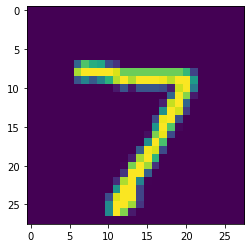

In [4]:
%matplotlib inline
img = test.iloc[0,1:].values
img = img.reshape(28,28)
plt.imshow(img);

### Datset and Dataloaders

Pytorch provides utilities to load data called Dataset. you can read about pytorch dataset dataloaders and transforms [here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

Below is a sample implementation of a dataset that loads flat images along with labels. It takes input path to csv files and loads a single image and its label. With the help of transforms class the loaded image is converted to a tensor and scaled so that max value is One.

In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch


class MnistDataSet(Dataset):
    '''A dataset object that reads from a CSV file and returns flat image '''
    
    def __init__(self,path, transform=None):
        self.data= pd.read_csv(path,header=None).values
        self.transform = transform
        
        #get the maximum number of unique elements. 
        self.n_labels = len(np.unique(self.data[:,0]))
        
    def __len__(self):
        return self.data.shape[0]
        
    def __getitem__(self,index):
        label = self.data[index,0]
        img = self.data[index,1:]
        if self.transform:
            img = self.transform(img)
        return img,torch.tensor(label)

        
        
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, img):
        return torch.from_numpy(img)
    
class Rescale(object):
    """."""
    
    def __init__(self,scale):
        self.scale = scale

    def __call__(self, img):
        return img/self.scale
        
trs = transforms.Compose([ToTensor(),Rescale(255)])
        
        
test_data = MnistDataSet("mnist_test.csv",trs)
train_data = MnistDataSet("mnist_train.csv",trs)

In [6]:
test_data[0]

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

#### torch DataLoader

Most of the time we process data in batches as it helps speed up training. The size of the batch depends on the amount of data we can fit into memory (RAM and GPU) at a time. We also want to shuffle the data after every run so that out model is trained on batches of data grouped differently. Further we also like to exploit multi processing for loading data (Eg 4 cpu cores can be used to load 4 batches at a time. This works well with multi Gpu training). The DataLoader utility allows us to do this. It takes in input a dataset and some additional parameters like batch_size, num_workers (cores used for loading data) and shuffle.   

In [7]:
#num_workers set to zero as all images are loaded in memory. THis is not a good way to load data but since images are small we can get away with it.
test_loader = DataLoader(test_data, batch_size=8,num_workers=0)
train_loader = DataLoader(train_data, batch_size=8,num_workers=0)

In [8]:
#for batch size 8  8 sets of images and labels are loaded by dataloader
for batch,(data,label) in enumerate(test_loader):
    print(batch,data.size())
    break

0 torch.Size([8, 784])


### Neural Network

Below is a sample implementation of neural network in PyTorch. It is done by inheriting the torch.nn.Module class and implementing forward and init methods. The nn.Module class has additional methods (you can check them with `dir(nn.Module)`) that handle all the other computations required by neural networks

In [9]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self, n_input_nodes):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(n_input_nodes, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = self.fc1(x)
        return self.fc2(x)

net = Net(784)
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


### network parameters


Please go through chapter 3.1 - 3.4 for linear neural networks https://d2l.ai/chapter_linear-networks/index.html

The network above has 3 layers an input (size 784) hidden (size 64) and output layer (size 10).  All layers with inputs (in this case the hidden and output) will have weights and biases associated with them. When the input is passed it is multiplied by this weight matrix and and the bias is added to get sample output. The weights are initialized randomly. The goal is to find best set of weights and biases.

For a layer with 64 output and 784 input the number of weights are given 784*64 and is represented by a 64,784 matrix. The number of biases are 64 (equal to the number of output neurons)
the intermediate output is then given by
$$O = W.X+ B$$ WHERE W = weight matrix, X = input and B = bias matrix

The final output in our case would be size 10 each value being a probability (if softmax is applied) for 10 classes (0-9). Ex `[0.01,0.02,0.7,0.1,0.07,0.05,0.05,0.,0.,0.]` can be read as probability of the output being 0 is 0.01 ,1 is 0.02 ,2 is 0.7 and so on. During prediction we simply take the argmax which in this case would be 2 and say that the output for the given input as predicted is 2.

In [10]:
net.fc1.weight.shape, net.fc1.bias.shape

(torch.Size([64, 784]), torch.Size([64]))

### Loss function

For categorical classification generally cross entropy loss is used. More about Cross entropy loss [here](https://gombru.github.io/2018/05/23/cross_entropy_loss/).

Pytorch implementation of the loss using CrossEntropyLoss() assumes that softmax activation  is not applied to the input. Softmax activation is required to convert raw output from the network to probability. CrossEntropy is only defined between probabilities. In our case since the target is a digit between 0-9 behind the scene is it one hot encoded by the function.
An example one hot representation for 7 is `[0,0,0,0,0,0,1,0,0,0]`.  This is interpreted as 100 percent probability that given number is 7. This allows the network to compare it's output with label using cross entropy.

In pytorch you can find the gradients of output with respect to the input (in our case all layers in the neural net) when `.backward()` method is called. Every parameter in our network has gradient saved as grad attribute. eg `net.fc1.weights.grad` will have the gradients for that layer. `.backward()` method simply updates this grad attribute.

In [11]:
out = net(torch.randn(784))

In [12]:
criterion = nn.CrossEntropyLoss()
target = torch.Tensor([7]).type(torch.LongTensor)  # a dummy target
out = out.view(1,-1)
loss = criterion(out, target)

In [13]:
loss,loss.tolist()

(tensor(2.6068, grad_fn=<NllLossBackward>), 2.6067605018615723)

### optimizer

Below Stochastic Gradient Descent is used as the optimizer. It takes in input as network parameters and learning rate. learning rate is an important parameter and it affects the training of the model the most. Optimzer will update network (`.grad` attribute) parameter when `.step()` method is called. 

In [14]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# Q1

The function below is used to train and validate the dataset. IT is a general function that takes in model, loss, optimizer, train and test dataloaders and epochs. A fucntion like this can be used in a UI based set up to train moodel based on user selection etc. Use suitable functions to compute train and test accuracies along with the train and test loss.

In [18]:
def train_fn(model, criterion, optimizer, train_dataloader, test_dataloader, epochs):
    
#     #move model to gpu
    gpu=False
#     if torch.cuda.is_available():
#         device = torch.device(0)
#         gpu=True
#         model.to(device)
    
    
    for _ in range(epochs):
        for i,dataloader in enumerate([train_dataloader,test_dataloader]):
            
            # iterate through datalaoder once
            batch_loss = 0
            for batch,(data,label) in enumerate(dataloader):
                    
                #zero gradients
                optimizer.zero_grad() #zeros network parameters 
                
                # calculate output
                output = model.forward(data)

                # compute loss
                loss = criterion(output, label)
                
                batch_loss+=loss.tolist()#convert from tensor to scalar

                # backward pass
                loss.backward()

                #step optimizer
                optimizer.step()

                
            if i==0:
                print("train Loss: ", batch_loss/len(train_dataloader)) #average loss for train set
            else:
                print("test Loss: ",batch_loss/len(test_dataloader)) # average loss for test set
                
    print("saving models")
    
    PATH = "./eval_2_net.pth"
    torch.save(model.state_dict(), PATH)
            
            
    return model

In [19]:
trained = train_fn(net, criterion, optimizer, train_loader, test_loader, epochs=2)

train Loss:  0.28755411873698855
test Loss:  0.26017215865468607
train Loss:  0.27976649242810286
test Loss:  0.2545114815360401
saving models


### Q2

Implement a convolutional neural network to and train using the above fucntion. Implement a transform class called Reshape that takes a 1,748 array and shapes in into 28,28 so that it is a 2d image. refer to https://d2l.ai/chapter_convolutional-neural-networks/index.html for the convolutional neural network

In [27]:
class Reshape(object):
    def __call__(self, img):
        # torch.reshape(img, (28,28))
        return img.view(1,28,28)
    

trs = transforms.Compose([ToTensor(),Reshape(),Rescale(255)])
del test_data,train_data
test_data = MnistDataSet("mnist_test.csv",trs)
train_data = MnistDataSet("mnist_train.csv",trs)

test_loader = DataLoader(test_data, batch_size=8,num_workers=0)
train_loader = DataLoader(train_data, batch_size=8,num_workers=0)

class ConvNet(nn.Module):

    def __init__(self, n_input_shape):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 3)
        self.fc1 = nn.Linear(10 * 5 * 5, 64)
        self.fc2 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
new_model = ConvNet([28,28])

train_fn(new_model, criterion, optimizer, train_loader, test_loader, epochs=2)

train Loss:  2.303993288199107
test Loss:  2.303826543235779
train Loss:  2.303993288199107
test Loss:  2.303826543235779
saving models


ConvNet(
  (conv1): Conv2d(1, 5, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=250, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)